<a href="https://colab.research.google.com/github/NamasteAI/ToxicCommentsClassifier/blob/main/ToxicCommentClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#df = pd.read_csv('/content/drive/MyDrive/KaggleToxicCommentDataset/train.csv')
df = pd.read_csv('/Users/itscodezero/Documents/UOL/M6-NLP/MMA/data/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Add a new column 'non-toxic' to the DataFrame with values 0 or 1, where 0 represent the comment falls under any one of the category
df['non-toxic'] = (df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)
df['non-toxic'] = df['non-toxic'].astype(int)  # Convert boolean to integer (True -> 1, False -> 0)

In [6]:
toxicity_counts = df.iloc[:, 2:].apply(pd.Series.value_counts)
print(toxicity_counts)

    toxic  severe_toxic  obscene  threat  insult  identity_hate  non-toxic
0  144277        157976   151122  159093  151694         158166      16225
1   15294          1595     8449     478    7877           1405     143346


In [7]:
# Get the positive count of each category
category_totals = toxicity_counts.iloc[1].sort_values(ascending=False)
print(category_totals)

non-toxic        143346
toxic             15294
obscene            8449
insult             7877
severe_toxic       1595
identity_hate      1405
threat              478
Name: 1, dtype: int64


<Axes: >

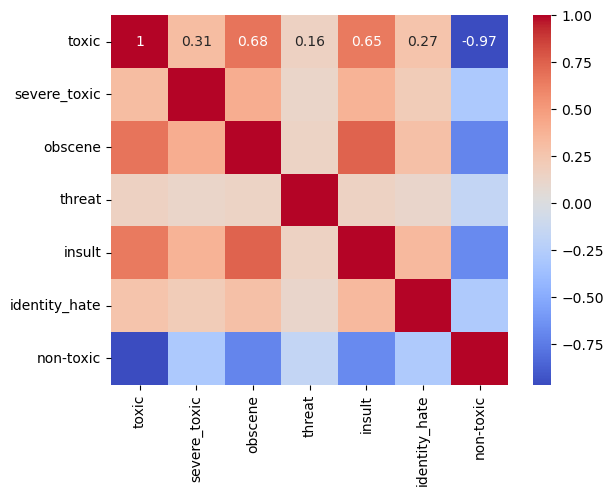

In [8]:

# Calculate the correlation matrix 
corr_matrix = df.iloc[:, 2:].corr()

# Plot the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

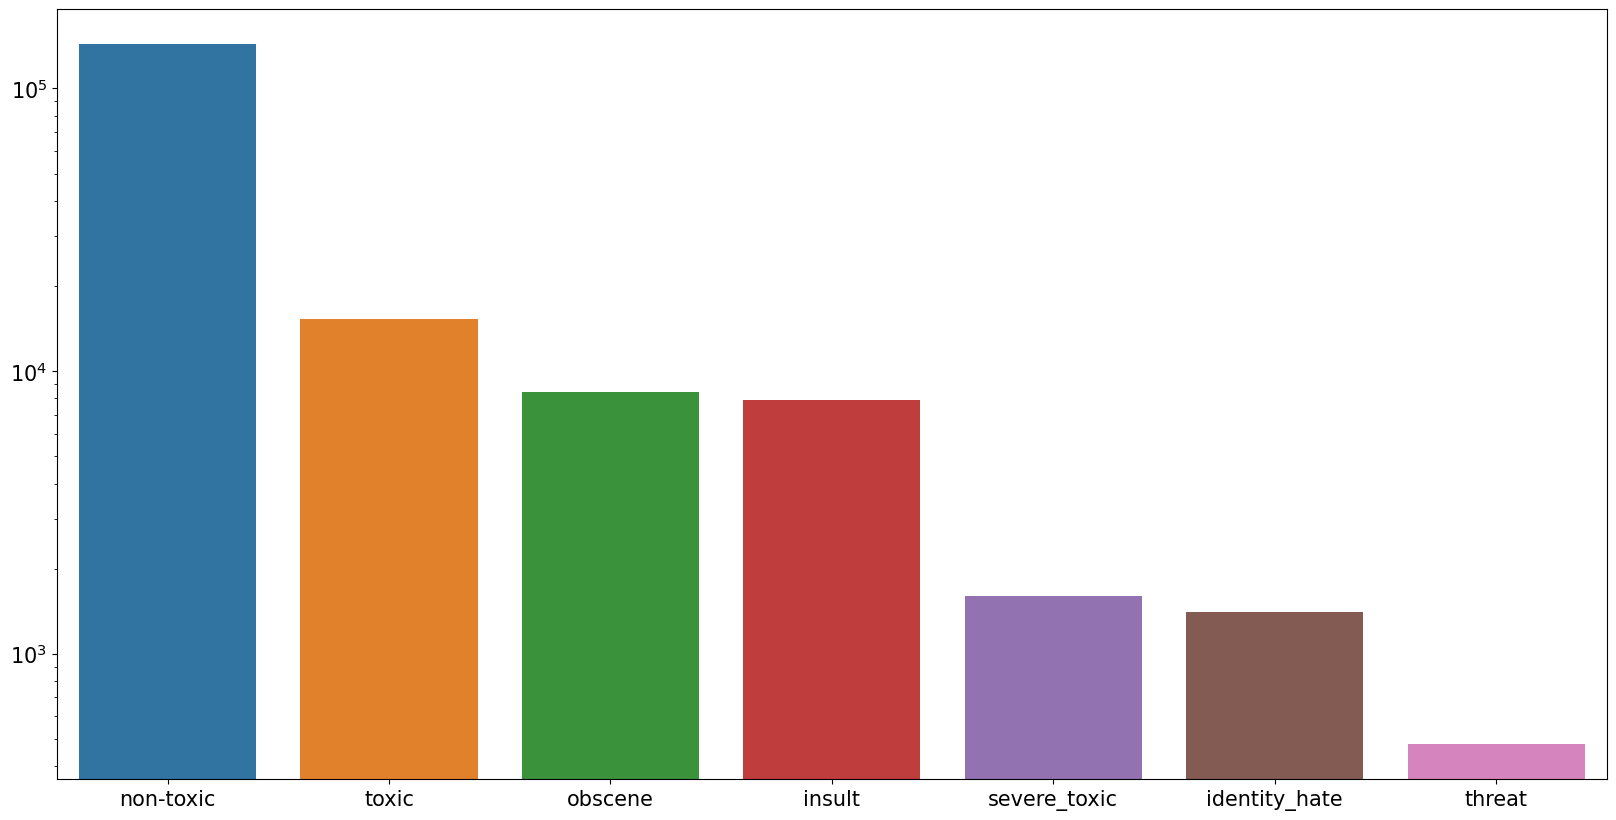

In [9]:

plt.figure(figsize=(20, 10))
bp = sns.barplot(x=category_totals.index, y=category_totals.values)
bp.set_yscale("log")
bp.tick_params(labelsize=15)

## Dataset balancing

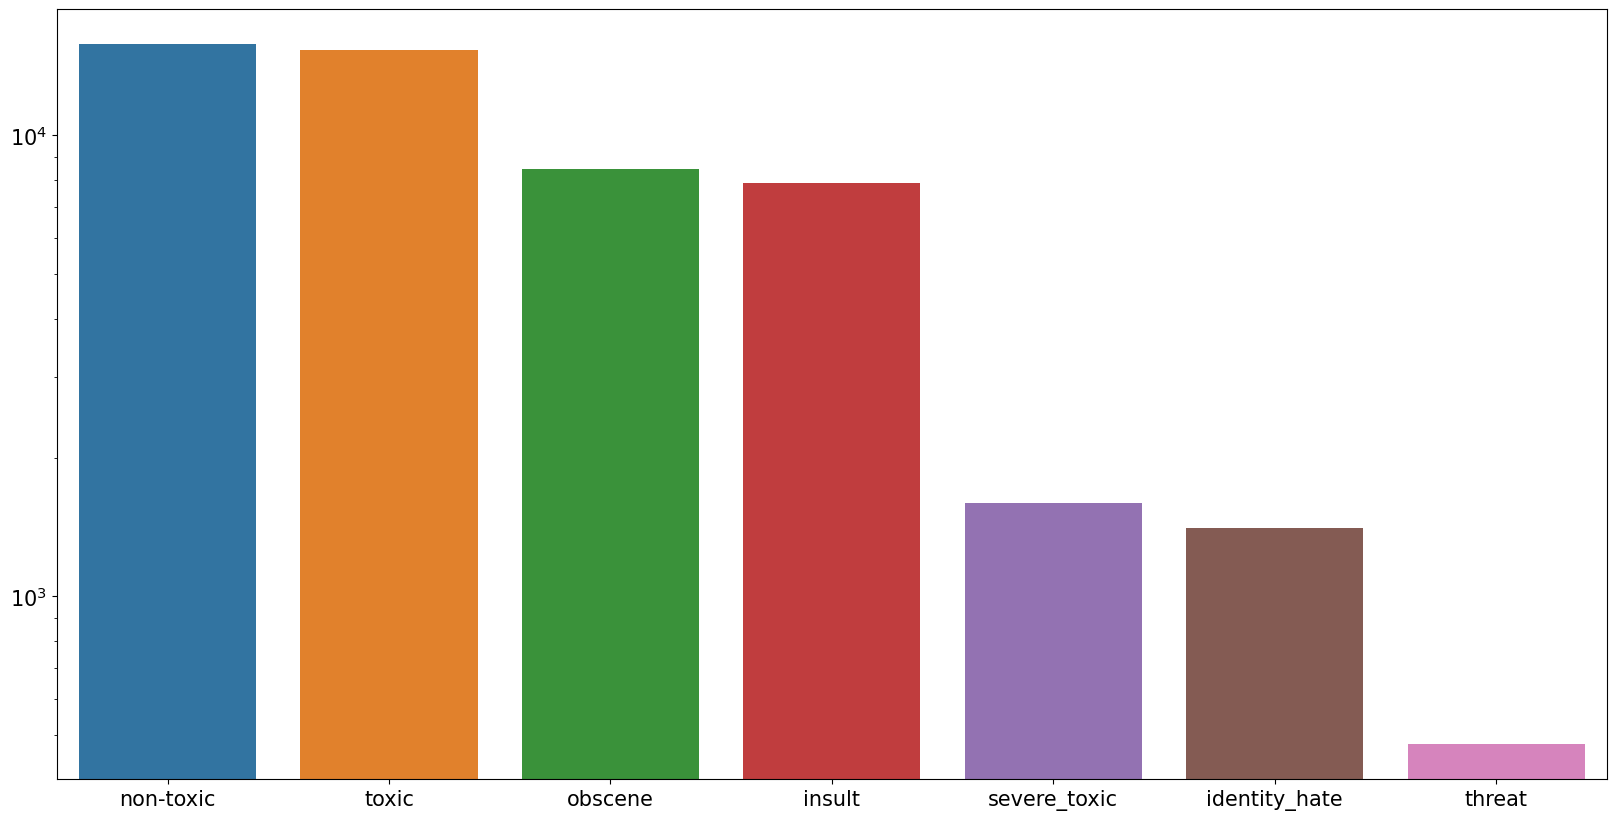

In [10]:
df_balanced = pd.concat([df[df['non-toxic'] == 1].sample(frac=0.11), df.loc[df['non-toxic'] == 0]])

# Shuffle the DataFrame
df_balanced = df_balanced.sample(frac=1)

toxicity_counts = df_balanced.iloc[:, 2:].apply(pd.Series.value_counts)
category_totals = toxicity_counts.iloc[1].sort_values(ascending=False)

plt.figure(figsize=(20, 10))
bp = sns.barplot(x=category_totals.index, y=category_totals.values)
bp.set_yscale("log")
bp.tick_params(labelsize=15)


# Preprocessing

In [11]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# Load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):

    # Normalize text (convert to lowercase)
    text = text.lower()
    
    # Initialize SpaCy
    doc = nlp(text)
    
    # Lemmatize and remove stopwords
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    # Join tokens back into text
    text = ' '.join(tokens)
    
    return text

print('Unprocessed text:', df_balanced['comment_text'].head())
# Apply preprocessing to the 'comment_text' column
df_balanced['comment_text'] = df_balanced['comment_text'].apply(preprocess_text)
print('Processed text:', df_balanced['comment_text'].head())

/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Unprocessed text: 24321     IMDB text \n\nMost of this article is lifted d...
37389     I will fucking cut your heart out. I will set ...
9272      read \n\nPhoenix Stone (sam licita) was a memb...
103677    "\n\n%) Igor intervention to explain the error...
150274    Leaving two references for people to see \n\nh...
Name: comment_text, dtype: object
Processed text: 24321     imdb text \n\n article lift directly imdb .   ...
37389           fucking cut heart . set fire motherfucker .
9272      read \n\n phoenix stone ( sam licita ) member ...
103677    " \n\n % ) igor intervention explain error com...
150274    leave reference people \n\n http://www.fillesd...
Name: comment_text, dtype: object


In [14]:
X = df_balanced['comment_text']
# take the columns from 2 to the 1 before the last one
y = df_balanced[df_balanced.columns[2:-1]].values
#print column names from y
print(df_balanced.columns[2:-1])

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


In [148]:
from tensorflow.keras.layers import TextVectorization

In [149]:
MAX_FEATURES = 200000

In [150]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [151]:
vectorizer.adapt(X.values)

In [152]:
vectorizer('hello, how are you?')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([  218, 46722, 14363, ...,     0,     0,     0])>

In [153]:
vectorizer_text= vectorizer(X.values)

In [154]:
vectorizer_text

<tf.Tensor: shape=(31993, 1800), dtype=int64, numpy=
array([[   56,  1147,  2767, ...,     0,     0,     0],
       [39741,   231,     5, ...,     0,     0,     0],
       [13184,  1478,    68, ...,     0,     0,     0],
       ...,
       [    7,  1884,   847, ...,     0,     0,     0],
       [ 1686,  2658,   526, ...,     0,     0,     0],
       [   18,   100,     8, ...,     0,     0,     0]])>

In [155]:
dataset = tf.data.Dataset.from_tensor_slices((vectorizer_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [156]:
batchX, batchy = dataset.as_numpy_iterator().next()

In [157]:
train = dataset.take(int(len(dataset)* .7))
val = dataset.skip(int(len(dataset)* .7)).take(int(len(dataset)* .2))
test = dataset.skip(int(len(dataset)* .9)).take(int(len(dataset)* .1))

### Create Sequential Model

In [159]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding

In [160]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation= 'tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation= 'relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6,activation='sigmoid'))

In [161]:
model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer='Adam')

In [ ]:
model.summary()

In [ ]:
history = model.fit(train, epochs=1, validation_data=val)

In [ ]:
model.evaluate(test)

In [ ]:
history.history

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Evaluation metrics

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
cat_acc = CategoricalAccuracy()

In [ ]:

for batch in test.as_numpy_iterator():
    # Divide the batch into X_true and y_true
    X_true, y_true = batch

    # Make a prediction
    y_pred = model.predict(X_true)

    # flatten the prediction
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, y_pred)
    re.update_state(y_true, y_pred)
    cat_acc.update_state(y_true, y_pred)


    

In [ ]:
print (f'Precision {pre.result().numpy()}, Recall {re.result().numpy()}, Accuracy {cat_acc.result().numpy()}')

In [ ]:
print(classification_report(y_true, y_pred))
print(f'AUC: {roc_auc_score(y_true, y_pred)}')

# BERT Classifier

In [ ]:
!pip install --upgrade keras-nlp
!pip install --upgrade kerasd

In [ ]:

# Create a BERT classifier model
b_model = BertClassifier(num_classes=6)

# Compile the model
b_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=3, validation_data=val)

# Evaluate the model
b_model.evaluate(test)

In [ ]:
history.history

In [ ]:
plt.figure(figsize=(8, 5))
pd.DataFrame(history.history).plot()
plt.show()

# Make predictions
input_text = vectorizer('you are stupid person, you are an ass and ugly and fraud')
input_text = np.expand_dims(input_text, 0)
predictions = b_model.predict(input_text)
print(predictions)

In [ ]:
pre = Precision()
re = Recall()
cat_acc = CategoricalAccuracy()

In [ ]:

for batch in test.as_numpy_iterator():
    # Divide the batch into X_true and y_true
    X_true, y_true = batch

    # Make a prediction
    y_pred = model.predict(X_true)

    # flatten the prediction
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, y_pred)
    re.update_state(y_true, y_pred)
    cat_acc.update_state(y_true, y_pred)


    

In [ ]:
print (f'Precision {pre.result().numpy()}, Recall {re.result().numpy()}, Accuracy {cat_acc.result().numpy()}')